 # Evaluation of recharge

 We have a model with weekly Stress Periods that have to run for 3 years (SP= 1:36) for which we need to define the recharge (RCH pkg).  
 We have available from istSOS services daily precipitation (sum), daily temperature (min, max, ave) and daily groundwater level (ave).  
 
 *Question:*  
     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
     Evaluate if the recharge (calculated as preciptation minus evaporation) is the only responsible for waterlevel fluctuation.*
 
 ---
**NOTE**  
    
    *Required Knowledge*
    - How sensing devices and monitoring networks works
    - What is Sensor Observation Service OGC standard
    - What is the concept of the oatlib tool

    **Learned Skills**
    - How to set-up an istSOS service
    - How to collect, archive and distribute sensor data
    - How to access and process online data with oatlib
---
 
 **Process:**
 
 1. create an OAT.sensor and load HEAD data from csv
 2. create an OAT.sensor and load data of RAIN from istSOS
 3. create an OAT.sensor and load data of TEMP from istSOS
 4. estimate ETP using the Hargreaves formula
 5. estimate the recharge RCH calculated as preciptation minus evaporation
 6. plot the HEAD vs RCH
 7. evaluate the correlation among the two

----------




### Define nb settings and import python libraries

In [6]:
# setting notebook preferences
%load_ext autoreload
%autoreload 2
%matplotlib inline
#!pip uninstall oatlib --yes
#!pip install oatlib --no-cache

#magic import of OAT for DEVEL
import sys
sys.path.insert(0, "/home/maxi/GIT/OAT")
import oatlib

#try:
#    import oatlib
#except:
#    ! pip install oatlib #--> this will install oatlib if is not present

import requests
import json
from oatlib import sensor, method, oat_utils
from dateutil import parser, relativedelta
import matplotlib.pyplot as plt
from statistics import stdev
from datetime import datetime, tzinfo, timedelta
import dateutil


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
server = 'https://geoservice.ist.supsi.ch/vedeggio'
service = 'vedeggio'
user = 'alberto.vancheri@supsi.ch'
pwd = 'pt2RkNw'

In [24]:
event_time = '2016-03-11T11:20:00+0100/2019-09-06T14:00:00+0100'
#event_time = '2019-07-05T11:20:00+0100/2019-09-06T14:00:00+0100'

observed_property_name = 'water-height'
observed_property_uom = 'm'

istsos_url = '{}/{}'.format(server, service)
basic_auth = (user, pwd)

SENSOR = sensor.Sensor(
    name='VED_MAN',
    prop='water:height',
    unit='m'
)

SENSOR.ts_from_istsos(
    service=istsos_url,
    observed_property='water:height',
    procedure='VED_MAN',
    basic_auth=(user, pwd),
#     aggregate_function='AVG',
#     aggregate_interval='PT10M',
    event_time=event_time,
    delta=relativedelta.relativedelta(days=15)
)
print('-->DONE\n')
print(SENSOR)

Retrieving data...2019-09-06 14:00:00+01:00-->DONE

name: VED_MAN
desc: None
lat: None
lon: None
alt: None
tz: +01:00
unit: b'm'
prop: water:height
freq: None
statflag: None
use: True
data_availability: ['2016-03-18T04:20:00.000000000', '2019-09-06T13:00:00.000000000']
ts:                         data  quality
time                                 
2016-03-18 04:20:00  291.180      210
2016-03-18 04:30:00  291.180      210
...                      ...      ...
2019-09-06 12:50:00  291.418      210
2019-09-06 13:00:00  291.413      210

[177036 rows x 2 columns]



### Configure istSOS server

### Let's see the available sensors and data

In [9]:
procedures = oat_utils.get_istSOS_Procedures(server, service, user, pwd)
oat_utils.filter_procedures(procedures,'name','=','T_TRE')[0]

{'samplingTime': {'beginposition': '2016-03-11T11:20:00+0100',
  'endposition': '2019-09-12T11:00:00+0200'},
 'sensortype': 'insitu-fixed-point',
 'observedproperties': [{'name': 'water-conductivity', 'uom': 'μS/cm'},
  {'name': 'water-height', 'uom': 'm'},
  {'name': 'water-temperature', 'uom': '°C'}],
 'description': 'Water level, water temperature and water electrical conductivity recorder Vedeggio',
 'name': 'VED_MAN',
 'assignedid': 'c941529affe411e581500800279a042f',
 'offerings': ['temporary'],
 'id': 1}

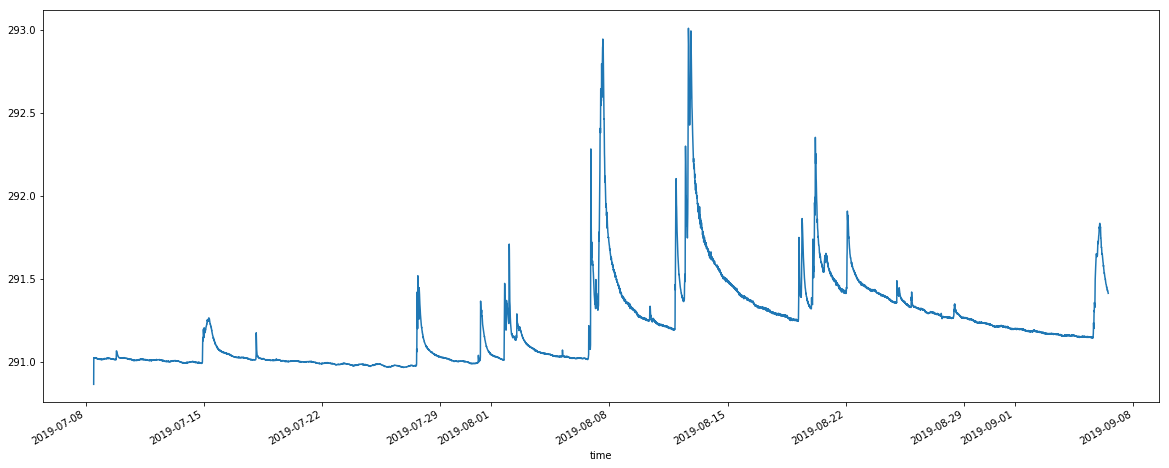

In [22]:
SENSOR.ts['data'].plot(figsize=(20,8))

In [23]:
SENSOR.ts['data']['2016'].plot(figsize=(20,8))

KeyError: '2016'

In [13]:
import time

for i in range(10):  
    print(i, end="\r")
    time.sleep(0.5)

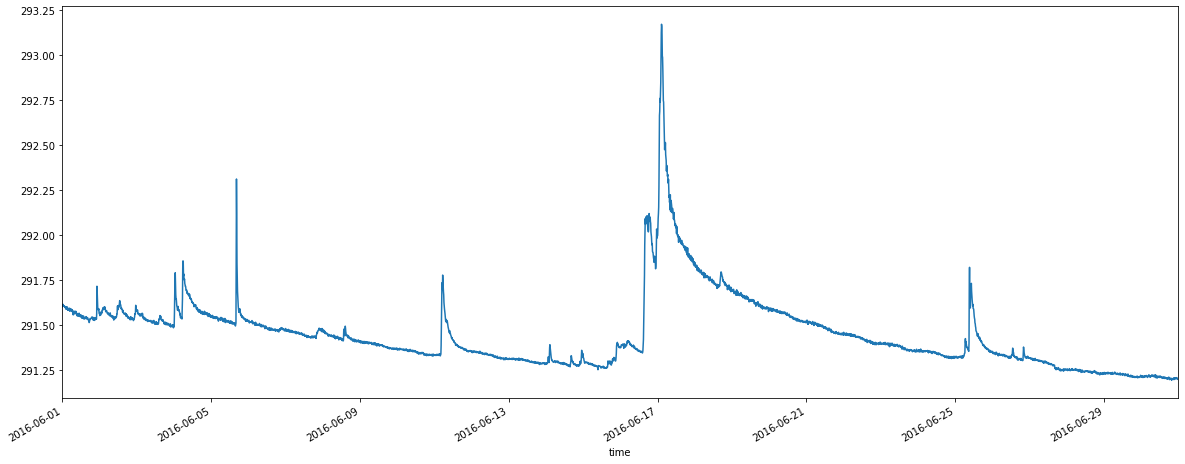

In [15]:
SENSOR.ts['data']['2016-06'].plot(figsize=(20,8))

In [7]:
SENSOR = sensor.Sensor(
    name='procedure_name',
    prop='water-discharge',
    unit='m3/s'
)
SENSOR.ts_from_csv(
    'OpenScienceTutorial/oat/data/Q_VED_ISO_20180101000000000000.dat',
    qualitycol=2,
    sep=',',
    skiprows=1
)

/home/maxi/Documents/2019/didattica/PisaSummerSchool/OBS4RCH/venv/lib/python3.6/site-packages/oatlib/sensor.py:379: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  if len(self.ts.index.get_duplicates()) > 0:


In [16]:
SENSOR.ts.head(10)

,data,quality
time,,
2016-03-18 05:20:00+01:00,291.18,210
2016-03-18 05:30:00+01:00,291.18,210
...,...,...
2016-03-18 06:40:00+01:00,291.18,210
2016-03-18 06:50:00+01:00,291.17,210


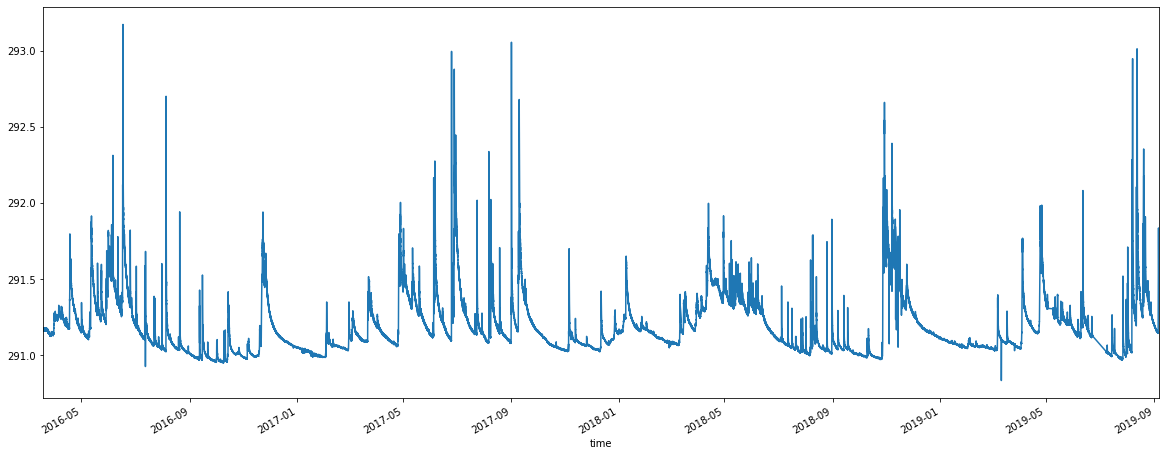

In [17]:
SENSOR.ts['data'].plot(figsize=(20,8))

## Formula di Hargreaves
ETo = 0.0023 RA TD1/2 (T+17.8)

dove:

RA= radiazione extraterrestre (MJ m-2 d-1)

T= temperatura media dell’aria (°C)

TD = differenza tra temperatura max e min (medie) nel periodo (°C)

# Preparing RCH input data

- download daily precipitation data in the basin
- download daily max temperature data in the basin
- calculate ETP
- aggregate every 7 days (this is your StressPeriod length)
- 

In [60]:
# Find the delta between two dates based on a desired number of ranges
def datedelta(startdate, enddate, no_of_ranges):
    start_epoch = calendar.timegm(startdate.timetuple())
    end_epoch = calendar.timegm(enddate.timetuple())

    date_diff = end_epoch - start_epoch

    step = date_diff / no_of_ranges

    return datetime.timedelta(seconds=step)

def datespan(startdate, enddate, delta=datetime.timedelta(days=1)):
    currentdate = startdate

    while currentdate < enddate:
        todate = (currentdate + delta)
        
        if todate > enddate:
            todate = enddate

        yield currentdate, todate

        currentdate += delta
        currentdate.replace(hour=0, minute=0,second=0)

In [64]:
event_time = '2018-05-01T00:10:00+0100/2018-06-01T02:00:00+0200'
import dateutil
startdate, enddate =  (map(parser.parse,event_time.split("/")))
delta = relativedelta.relativedelta(weeks=+1)

In [65]:
for from_datetime, to_datetime in datespan(startdate, enddate, delta):
        print(from_datetime, to_datetime)

2018-05-01 00:10:00+01:00 2018-05-08 00:10:00+01:00
2018-05-08 00:10:00+01:00 2018-05-15 00:10:00+01:00
2018-05-15 00:10:00+01:00 2018-05-22 00:10:00+01:00
2018-05-22 00:10:00+01:00 2018-05-29 00:10:00+01:00
2018-05-29 00:10:00+01:00 2018-06-01 02:00:00+02:00
